# Topic Modeling

- we want to perform topic modeling on the test set
- we can perform the hyperparameter adjustment on validation set

In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import os
import numpy as np
import tqdm
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim import models
from gensim.utils import ClippedCorpus

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd

## Data Preparation

### Dataset creation

In [2]:
# import os
# import pandas as pd
# from pandas.core.common import flatten

In [3]:
# path_dataset = './Dataset_TLDRHQ/processed_dataset/'
# path_output = './Dataset_TLDRHQ/dataset_topic_modeling/'

# for file in os.listdir(path_dataset):
#     if 'val' in file:
#         print(file)
#         json = pd.read_json(f'{path_dataset}{file}', orient="records", lines=True)
#         json['document_normalized'] =  json['document_normalized'].apply(lambda x: list(flatten(x)))
#         json['pos_tags'] =  json['pos_tags'].apply(lambda x: list(flatten(x)))
#         json[['id', 'document_normalized', 'pos_tags']].to_json(f'{path_output}{file}', orient = "records", lines=True)

### Data loading

In [4]:
path = './Dataset_TLDRHQ/dataset_topic_modeling/'

# train = []

for file in os.listdir(path):
    if 'val' in file:
        val = pd.read_json(f'{path}{file}', orient="records", lines=True)
        print(file)
    if 'test' in file:
        test = pd.read_json(f'{path}{file}', orient="records", lines=True)
        print(file)
    # if 'train' in file:
    #     temp = pd.read_json(f'{path}{file}', orient="records", lines=True)
    #     train.append(temp)
    #     print(file)

# train = pd.concat(train)

test.json
val.json


### Data Exploration - pre processing

In [5]:
test

,id,document_normalized,pos_tags
0,train-TLDR_RC_2018-10-cm-19097.json,"[danieldrepper, und, ich, hier, wir, sehen, be...","[NOUN, NOUN, VERB, ADJ, NOUN, NOUN, NOUN, ADV,..."
1,train-TLDR_RS_2013-03-21448.json,"[dating, since, august, last, year, one, point...","[VERB, ADP, NOUN, ADJ, NOUN, NUM, NOUN, NOUN, ..."
2,train-TLDR_RS_2012-04-12146.json,"[life, find, school, wing, chun, eager, learn,...","[NOUN, VERB, NOUN, VERB, NOUN, NOUN, VERB, VER..."
3,train-TLDR_RC_2018-10-cm-10081.json,"[mixed, chinese, malay, would, like, put, prim...","[ADJ, ADJ, NOUN, VERB, VERB, VERB, ADJ, NOUN, ..."
4,train-TLDR_RC_2013-04-cm-47367.json,"[make, sense, thought, renting, condo, apartme...","[NOUN, NOUN, VERB, VERB, ADJ, NOUN, VERB, VERB..."
...,...,...,...
40276,TLDR_RS_2020-05-cm-33121.json,"[recently, started, playing, battle, network, ...","[ADV, VERB, VERB, NOUN, NOUN, ADP, VERB, NUM, ..."
40277,TLDR_RS_2020-11-cm-29098.json,"[looking, buy, first, car, honestly, know, not...","[VERB, VERB, ADJ, NOUN, ADV, VERB, NOUN, ADJ, ..."
40278,TLDR_RS_2020-08-cm-29716.json,"[met, really, nice, girl, work, came, city, ri...","[VERB, ADV, ADJ, NOUN, NOUN, VERB, NOUN, ADV, ..."
40279,TLDR_RS_2020-11-cm-22864.json,"[first, series, rant, star, citizen, inconsist...","[ADJ, NOUN, NOUN, NOUN, ADJ, NOUN, NOUN, ADV, ..."


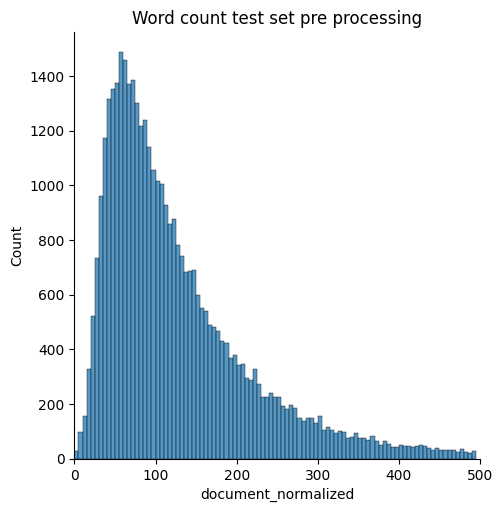

In [9]:
sns.displot(test['document_normalized'].apply(lambda x: len(x)), bins=range(0,500, 5)).set(title='Word count test set pre processing')
plt.xlim(0, 500)
plt.savefig('Images/word_count_pre.jpg')

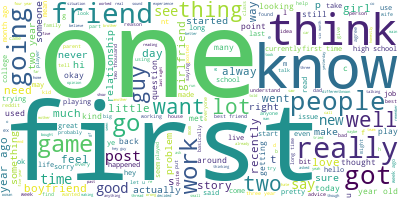

In [10]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(test['document_normalized'].to_string())

# Visualize the word cloud
wordcloud.to_file('Images/wordcloud_pre.png')
wordcloud.to_image()

### Data Processing

#### Verb and Noun filtering

In [11]:
col = []
for row in test.iterrows():
    a = []
    for i, elem in enumerate(row[1]['pos_tags']):
        if elem in ['NOUN', 'VERB']:
            a.append(row[1]['document_normalized'][i])

    col.append(a)

In [12]:
test['document_normalized'] = col

In [13]:
col = []
for row in val.iterrows():
    a = []
    for i, elem in enumerate(row[1]['pos_tags']):
        if elem in ['NOUN', 'VERB']:
            a.append(row[1]['document_normalized'][i])

    col.append(a)

In [14]:
val['document_normalized'] = col

#### Too frequent, infrequent and custom list words removal

In [15]:
stop_words = ['time', 'something', 'going', 'year', 'week', 'month', 'day', 'get', 'got', 'nt', 'want', 'know', 'thing', 'could', 'can', 'go', 'say', 'said']

test['document_normalized'] = test['document_normalized'].apply(lambda x: list(set(x)-set(stop_words)))

In [13]:
# test = test.loc[test['document_normalized'].apply(lambda x: len(x)) >= 5]

### Data exploration - post processing

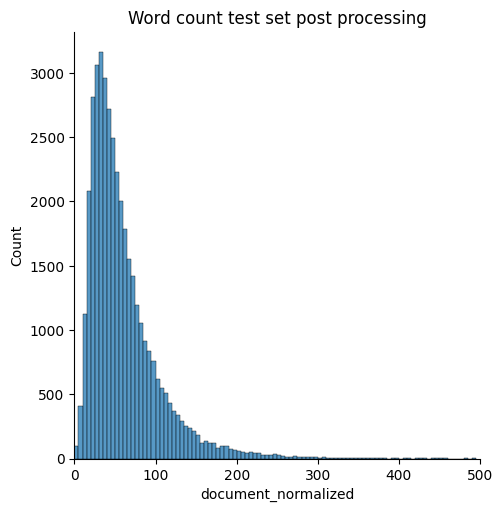

In [16]:
sns.displot(test['document_normalized'].apply(lambda x: len(x)), bins=range(0,500, 5)).set(title='Word count test set post processing')
plt.xlim(0, 500)
plt.savefig('Images/word_count_post.jpg')

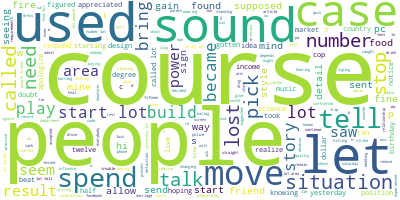

In [15]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(test['document_normalized'].to_string())

# Visualize the word cloud
wordcloud.to_file('Images/wordcloud_post.png')
wordcloud.to_image()

In [16]:
word_number = 10
min_df = 10
max_df = 0.5

## LDA

### Word Embedding - BoW

In [17]:
# Create Dictionary
id2word = Dictionary(test['document_normalized'])

In [18]:
print('before filter:\t\t', len(id2word))
id2word.filter_extremes(no_below=min_df)
print('low filter:\t\t', len(id2word))
id2word.filter_extremes(no_above=max_df) # low threshold because there is a wide variety of topics
print('high and low filter:\t', len(id2word))

before filter:		 75861
low filter:		 13536
high and low filter:	 13536


In [19]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in test['document_normalized']] # (word, freq) for every document
# corpus_val = [id2word.doc2bow(text) for text in val['document_normalized']]

### Hyperaparameter tuning

In [20]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [21]:
# Topics range
# topics_range = [10, 20, 30, 35, 50, 100]
topics_range = [5, 7, 20, 70, 150]

# Alpha parameter range (50/num_topics)
# alpha_range = [0.05, 0.1, 0.2, 0.5, 0.7, 1]
alpha_range = [0.005, 0.01, 0.02, 1.2, 1.5, 2]

# Beta parameter range
# beta_range = [0.05, 0.1, 0.2, 0.5, 0.7, 1, 1.5]
beta_range = [0.005, 0.01, 0.02, 1, 1.2, 1.5, 2]

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta_range)*len(alpha_range)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha_range:
                # iterare through beta values
                for b in beta_range:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word,
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    model_results = pd.DataFrame(model_results)
    pbar.close()

100%|██████████| 420/420 [2:21:13<00:00, 20.17s/it]  


In [ ]:
model_results.to_csv('Hyperparameters/tuning_2.csv', index=False)

In [22]:
file_list = []
for file in os.listdir('Hyperparameters/'):
    file_list.append(pd.read_csv(f'Hyperparameters/{file}'))

model_results = pd.concat(file_list)

In [23]:
model_results.sort_values('Coherence', ascending=False, inplace=True, ignore_index=True)
alpha = model_results['Alpha'][0]
beta = model_results['Beta'][0]
topics = model_results['Topics'][0]
model_results.head(10)

,Validation_Set,Topics,Alpha,Beta,Coherence
0,100% Corpus,20,1.2,1.5,-1.288327
1,100% Corpus,20,1.5,1.5,-1.288467
2,100% Corpus,20,2.0,1.5,-1.288488
3,100% Corpus,20,1.0,1.5,-1.288799
4,100% Corpus,30,0.7,1.5,-1.289363
5,100% Corpus,30,1.0,1.5,-1.289413
6,100% Corpus,35,0.7,1.5,-1.289785
7,100% Corpus,20,2.0,2.0,-1.289852
8,100% Corpus,20,0.7,1.5,-1.289921
9,100% Corpus,35,1.0,1.5,-1.290005


<AxesSubplot: xlabel='Topics', ylabel='Coherence'>

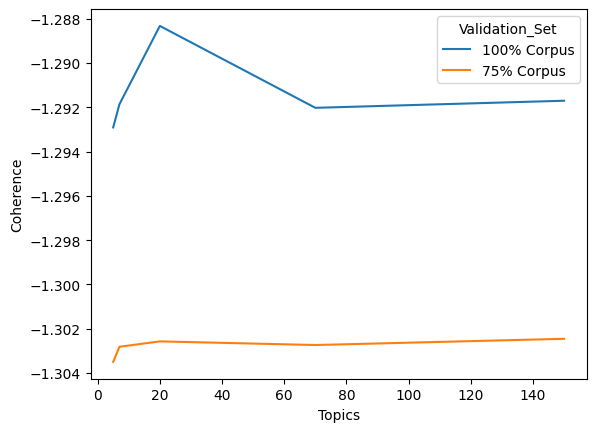

In [24]:
data = model_results.loc[(model_results['Alpha']==alpha)]
data = data[data['Beta']==beta]
sns.lineplot(data=data, x='Topics', y='Coherence', hue='Validation_Set', legend='brief')
# plt.savefig('Images/topic_number.png')

<AxesSubplot: xlabel='Alpha', ylabel='Beta'>

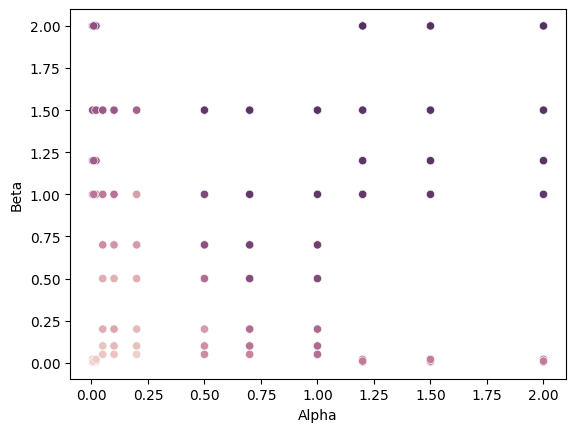

In [25]:
data = model_results.loc[model_results['Topics']==topics]
sns.scatterplot(data=data, x='Alpha', y='Beta', hue='Coherence', legend=None)
# plt.savefig('Images/scatter_alpha_beta.png')

### Performing LDA

In [27]:
# alpha = 0.05
# beta = 1
# topics = 35

In [26]:
# Build LDA model
lda_model = models.LdaMulticore(corpus=corpus,
                                 id2word=id2word,
                                 num_topics=topics,
                                 alpha=alpha,
                                 eta=beta,
                                 random_state=100)
                                 
# Print top 10 words of each topic
pprint(lda_model.print_topics(num_topics=topics))

[(0,
  '0.005*"make" + 0.005*"people" + 0.005*"think" + 0.004*"way" + 0.004*"see" + '
  '0.004*"work" + 0.004*"feel" + 0.004*"friend" + 0.003*"need" + 0.003*"take"'),
 (1,
  '0.005*"make" + 0.005*"think" + 0.004*"way" + 0.004*"people" + 0.004*"feel" '
  '+ 0.004*"see" + 0.004*"friend" + 0.004*"work" + 0.003*"lot" + 0.003*"take"'),
 (2,
  '0.005*"think" + 0.005*"make" + 0.005*"people" + 0.004*"way" + 0.004*"feel" '
  '+ 0.004*"see" + 0.004*"friend" + 0.003*"need" + 0.003*"lot" + 0.003*"take"'),
 (3,
  '0.005*"way" + 0.005*"people" + 0.005*"think" + 0.004*"make" + 0.004*"work" '
  '+ 0.004*"feel" + 0.004*"see" + 0.004*"need" + 0.003*"take" + 0.003*"lot"'),
 (4,
  '0.005*"think" + 0.005*"make" + 0.005*"way" + 0.005*"people" + 0.004*"see" + '
  '0.004*"feel" + 0.004*"friend" + 0.004*"lot" + 0.004*"work" + 0.003*"take"'),
 (5,
  '0.005*"way" + 0.005*"make" + 0.005*"think" + 0.005*"feel" + 0.004*"people" '
  '+ 0.004*"see" + 0.004*"friend" + 0.004*"work" + 0.003*"lot" + 0.003*"take"'),
 (6,


In [27]:
lda_results = pyLDAvis.gensim_models._extract_data(lda_model, corpus, id2word)
lda_doc_topic = pd.DataFrame(lda_results['doc_topic_dists'], columns = [f'Topic_{i}' for i in range(0,topics)])
# lda_doc_topic.to_csv('Dataset_TLDRHQ/Results_topic_modeling/lda_doc_topic.csv')
lda_doc_topic

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19
0,0.049773,0.049883,0.049470,0.049832,0.050354,0.050093,0.051093,0.050152,0.049280,0.049775,0.050002,0.049962,0.050058,0.049906,0.049916,0.050329,0.049894,0.050307,0.050326,0.049594
1,0.052077,0.051530,0.051938,0.050212,0.049023,0.049407,0.048988,0.049192,0.046420,0.048559,0.050739,0.052666,0.054758,0.049701,0.049562,0.048985,0.048827,0.048194,0.049449,0.049774
2,0.049750,0.050680,0.049555,0.050080,0.049905,0.050071,0.049719,0.051300,0.049798,0.051030,0.049976,0.050429,0.049337,0.048317,0.049532,0.049781,0.050135,0.050406,0.049856,0.050344
3,0.050405,0.048972,0.049032,0.049447,0.048953,0.053147,0.049213,0.050387,0.050711,0.051837,0.049871,0.049671,0.049816,0.050251,0.052293,0.047708,0.049911,0.048194,0.049063,0.051119
4,0.049626,0.051243,0.049517,0.049515,0.050004,0.049814,0.050117,0.050146,0.050082,0.050735,0.049713,0.050161,0.050120,0.048945,0.050599,0.050011,0.050067,0.050101,0.049720,0.049764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40276,0.049408,0.050752,0.050474,0.050987,0.049608,0.050434,0.051238,0.049581,0.049532,0.049905,0.048235,0.049046,0.046774,0.051382,0.048467,0.052665,0.050858,0.048876,0.050328,0.051450
40277,0.050330,0.050642,0.049569,0.050162,0.051619,0.049291,0.049198,0.048671,0.050339,0.050750,0.049773,0.050296,0.050694,0.048871,0.050043,0.049902,0.049997,0.049713,0.049687,0.050454
40278,0.050760,0.049273,0.050808,0.049486,0.051251,0.049762,0.048943,0.050346,0.049981,0.048704,0.050942,0.050241,0.052328,0.050394,0.048795,0.050094,0.048203,0.048189,0.051070,0.050431
40279,0.050306,0.050428,0.050258,0.050784,0.050093,0.049719,0.050578,0.049918,0.050847,0.049631,0.048708,0.049902,0.050043,0.049614,0.049100,0.051594,0.049935,0.049339,0.050723,0.048481


In [28]:
x=lda_model.show_topics(num_topics=topics, num_words=10, formatted=False)
topics_words = [(tp[0], [wd for wd in tp[1]]) for tp in x]

In [54]:
lda_topic_term = pd.DataFrame(topics_words, columns=['Topic', 'other'])#.transpose()
lda_topic_term = lda_topic_term.explode('other')
lda_topic_term[f'Top{word_number}Word'] = lda_topic_term['other'].apply(lambda x: x[0])
lda_topic_term['Score'] = lda_topic_term['other'].apply(lambda x: x[1])
lda_topic_term.drop('other', axis=1, inplace=True)
lda_topic_term.set_index(['Topic', f'Top{word_number}Word'], inplace=True)
# lda_topic_term.to_csv('Dataset_TLDRHQ/Results_topic_modeling/lda_topic_term.csv')
lda_topic_term

Score
Topic Top10Word          
0     make       0.005223
      people     0.005046
      think      0.004957
      way        0.004441
      see        0.003955
...                   ...
19    see        0.003681
      lot        0.003569
      friend     0.003491
      work       0.003308
      take       0.003216

[200 rows x 1 columns]

In [30]:
lda_topic_term.reset_index(inplace=True)
lda_topic_term['test'] = list(range(0,10))*topics
lda_top_terms = pd.pivot(lda_topic_term, index='test', columns='Topic', values=f'Top{word_number}Word')
lda_top_terms.reset_index(inplace=True)
lda_top_terms.drop('test', axis=1, inplace=True)
# lda_top_terms.to_csv('Dataset_TLDRHQ/Results_topic_modeling/lda_top_terms.csv')
lda_top_terms

Topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,make,make,think,way,think,way,way,make,make,make,people,think,think,think,think,make,think,people,people,think
1,people,think,make,people,make,make,make,think,think,think,think,make,people,people,make,think,way,make,think,make
2,think,way,people,think,way,think,think,people,way,people,make,people,make,make,way,way,people,think,make,people
3,way,people,way,make,people,feel,people,way,see,way,way,feel,way,feel,people,people,make,way,way,way
4,see,feel,feel,work,see,people,see,work,people,feel,see,way,see,see,see,feel,feel,work,see,feel
5,work,see,see,feel,feel,see,feel,see,friend,see,work,see,feel,way,feel,see,see,see,work,see
6,feel,friend,friend,see,friend,friend,friend,feel,feel,friend,feel,friend,work,work,friend,work,work,friend,feel,lot
7,friend,work,need,need,lot,work,work,friend,lot,work,take,work,need,friend,work,friend,friend,feel,friend,friend
8,need,lot,lot,take,work,lot,lot,take,work,need,friend,take,friend,lot,take,need,take,take,lot,work
9,take,take,take,lot,take,take,need,need,take,lot,need,need,lot,take,lot,lot,lot,lot,need,take


In [31]:
coherence = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass').get_coherence()
print(coherence)

-1.2883266383763678


In [32]:
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
lda_viz

C:\Users\gianl\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.000125 -0.000009       1        1  5.039769
19     0.000146 -0.000122       2        1  5.027674
10    -0.000015  0.000042       3        1  5.012551
3     -0.000127  0.000180       4        1  5.010147
14     0.000112 -0.000090       5        1  5.006955
7     -0.000162 -0.000035       6        1  5.005346
4     -0.000031  0.000062       7        1  5.004677
11     0.000096  0.000133       8        1  5.004400
2      0.000052  0.000086       9        1  5.003546
12    -0.000128  0.000142      10        1  5.002618
1      0.000075 -0.000087      11        1  5.001863
6     -0.000052 -0.000170      12        1  5.000631
5      0.000254  0.000136      13        1  4.993453
18    -0.000098 -0.000072      14        1  4.993206
9     -0.000046  0.000029      15        1  4.991636
8      0.000051 -0.000156      16        1  4.991440
13     0.000054  0.000022      17        1  4.986473
15     0.000031 -0.000079      18        1  4.986215
17    -0.000138 -0.000077      19        1  4.982204
16     0.000051  0.000067      20        1  4.955196, topic_info=        Term          Freq         Total Category  logprob  loglift
74      feel   8919.000000   8919.000000  Default  30.0000  30.0000
214      way  10265.000000  10265.000000  Default  29.0000  29.0000
148   people  10635.000000  10635.000000  Default  28.0000  28.0000
140     need   7366.000000   7366.000000  Default  27.0000  27.0000
128     make  11259.000000  11259.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
97      help    281.338656   5940.234162  Topic20  -5.9930  -0.0452
223  getting    284.377009   6119.669743  Topic20  -5.9823  -0.0642
806  someone    274.396181   5826.302429  Topic20  -6.0180  -0.0508
372     game    254.146207   5224.153092  Topic20  -6.0946  -0.0184
200  thought    255.648838   5536.379417  Topic20  -6.0887  -0.0706

[1646 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2337      1  0.052355  ability
2337      2  0.053324  ability
2337      3  0.050415  ability
2337      4  0.053324  ability
2337      5  0.047507  ability
...     ...       ...      ...
3574     16  0.056734     zone
3574     17  0.048629     zone
3574     18  0.048629     zone
3574     19  0.048629     zone
3574     20  0.048629     zone

[15360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 20, 11, 4, 15, 8, 5, 12, 3, 13, 2, 7, 6, 19, 10, 9, 14, 16, 18, 17])

## LSA

### Word Embedding - TF-IDF

In [62]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=(lambda a : a),
    preprocessor=(lambda a : a),
    token_pattern=None,
    min_df=min_df,
    max_df=max_df)

transformed = vectorizer.fit_transform(test['document_normalized'])

transformed.shape # check shape of the document-term matrix (tfidf matrix)

(40281, 13536)

### Peforming LSA

In [63]:
U, Sigma, VT = randomized_svd(transformed, 
                              n_components=topics,
                              n_iter=7,
                              random_state=None)

print(U.shape, Sigma.shape, VT.shape)

(40281, 20) (20,) (20, 13536)


In [64]:
terms = vectorizer.get_feature_names() # list of vocaboulary values

topic_list = []
terms_list = []
score_list = []
terms_only = []

for i, comp in enumerate(VT): # svd_model.components_ is the topic-term matrix
    topic_list.extend([i]*word_number)
    terms_comp = zip(terms, list(np.around(np.array(comp), 2)))
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:word_number]
    terms_list.extend(list(zip(*sorted_terms))[0])
    terms_only.append(list(zip(*sorted_terms))[0])
    score_list.extend(list(zip(*sorted_terms))[1])

lsa_topic_term = pd.DataFrame(list(zip(topic_list, terms_list, score_list)), columns=['Topic', f'Top{word_number}Word', 'Score'])
lsa_topic_term.set_index(['Topic', f'Top{word_number}Word'], inplace=True)
# lsa_topic_term.to_csv('Dataset_TLDRHQ/Results_topic_modeling/lsa_topic_term.csv')
lsa_topic_term

Score
Topic Top10Word       
0     feel        0.12
      friend      0.12
      make        0.12
      think       0.12
      people      0.11
...                ...
19    love        0.11
      way         0.11
      ask         0.10
      car         0.09
      thought     0.09

[200 rows x 1 columns]

In [65]:
lsa_top_terms = pd.DataFrame(terms_only).transpose()
# lsa_top_terms.to_csv('Dataset_TLDRHQ/Results_topic_modeling/lsa_top_terms.csv')
lsa_top_terms

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,feel,relationship,went,game,game,game,school,school,help,help,hundred,use,people,advice,hundred,people,work,question,anyone,someone
1,friend,friend,home,play,hundred,family,people,class,post,need,buy,school,hundred,anyone,hour,anyone,sex,asked,problem,find
2,make,girl,house,playing,money,parent,class,college,anyone,ask,looking,class,money,post,talk,problem,woman,help,sex,person
3,think,dating,car,player,play,life,friend,student,tried,try,love,girl,today,help,movie,friend,guy,lot,experience,kind
4,people,told,room,played,work,play,college,experience,found,people,family,hundred,everyone,looking,see,night,job,buy,girlfriend,hundred
5,see,boyfriend,came,friend,buy,mom,game,started,game,work,look,need,feel,question,night,issue,question,idea,advice,love
6,way,feeling,minute,guy,pay,playing,student,girl,issue,tell,anyone,parent,started,guy,text,hour,working,take,believe,way
7,lot,met,took,team,hour,kid,everyone,grade,today,anyone,bought,friend,buy,hundred,come,sex,asked,way,class,ask
8,relationship,talk,door,girl,playing,love,girl,looking,told,find,find,using,felt,team,lot,group,man,bit,idea,car
9,work,asked,hour,fun,friend,dad,kid,help,mom,look,found,mom,saying,twenty,question,party,men,told,night,thought


In [66]:
lsa_doc_topic = pd.DataFrame(U, columns = [f'Topic_{i}' for i in range(0,topics)])
# lsa_doc_topic.to_csv('Dataset_TLDRHQ/Results_topic_modeling/lsa_doc_topic.csv')
lsa_doc_topic

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19
0,0.000324,-0.000775,0.000137,0.000137,-0.001132,0.000223,0.000592,0.000453,0.000036,-0.001137,0.000018,-0.000235,-0.000264,0.000210,0.000490,-0.000832,0.001319,-0.000897,-0.000565,0.000699
1,0.010356,0.007441,0.000878,0.000558,-0.002484,0.004552,-0.007389,-0.004823,0.004537,-0.002376,-0.003230,-0.008821,0.004053,-0.005352,0.000056,0.003203,0.002536,0.002308,-0.003154,-0.000969
2,0.003139,-0.000578,-0.002518,-0.004764,0.000884,0.004724,0.003208,0.012575,0.005829,0.005664,0.003240,0.005448,-0.003031,0.004374,-0.003098,-0.000516,-0.007254,0.001007,0.002596,0.007171
3,0.006234,-0.003351,-0.009463,-0.002797,-0.008084,0.002068,0.000706,0.002162,-0.006215,0.003567,0.002159,0.001580,-0.001447,-0.001006,0.001584,-0.004500,-0.008901,-0.003006,0.002029,-0.001429
4,0.003084,-0.000342,0.001185,-0.004372,-0.000265,0.003038,-0.005442,-0.001133,-0.000440,0.002827,0.003697,-0.004206,-0.003397,-0.006088,-0.001267,0.000798,-0.003089,-0.001508,0.004563,0.000594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40276,0.005428,-0.007782,-0.000137,0.007902,0.006848,0.003570,-0.002480,0.000554,0.002618,-0.007318,0.001800,-0.004828,0.000128,-0.012974,-0.003997,-0.000606,-0.000057,0.002388,-0.009256,-0.002589
40277,0.003139,-0.003985,0.005602,-0.002397,0.008096,-0.006245,-0.005840,-0.000090,-0.002341,-0.006136,0.015702,0.002169,0.005379,0.004532,0.001591,0.002079,-0.004913,0.000431,0.000099,0.005326
40278,0.007664,0.002568,-0.000670,-0.001306,0.007106,-0.009511,-0.001438,0.002439,0.000011,0.000615,-0.004034,0.004206,-0.013692,-0.004989,0.007564,0.001643,0.005546,0.003533,-0.004582,0.011162
40279,0.003446,-0.004008,0.003060,-0.000183,-0.003385,-0.003021,-0.003529,-0.000226,-0.001675,0.000747,-0.001723,-0.004704,-0.006161,0.004711,0.002978,-0.006057,-0.007594,-0.001271,0.001577,-0.000882
